In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import gymnasium as gym

%reload_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('../survey_ops/utils')
sys.path.append('../survey_ops/')
import ephemerides
import geometry
import units
import environments
from offline_dataset import TelescopeDatasetv0
from agents import Agent
from algorithms import DDQN

: 

In [ ]:
from pytorch_utils import seed_everything

: 

# Load Data

In [ ]:
import json
with open("../data/2013-09-15_gband_fields.json") as f:
    old_id2pos = json.load(f)

: 

In [ ]:
id2pos = {}
for key in old_id2pos.keys():
    id2pos[int(key)] = old_id2pos[key]

: 

In [ ]:
import pandas as pd
schedule = pd.read_csv('../data/2013-09-15_gband_schedule.csv', dtype={'next_field':'Int64'})

: 

In [9]:
schedule_bad = schedule.copy()

In [10]:
schedule_bad

,time,field_id,next_field
0,1379248382,44,23
1,1379248544,23,53
2,1379248664,53,11
3,1379248794,11,16
4,1379248913,16,20
5,1379249032,20,54
6,1379249156,54,57
7,1379249275,57,33
8,1379249398,33,19
9,1379249529,19,9


In [7]:
field_id = 10
timestamp = schedule.iloc[field_id].time
field_ra, field_dec = id2pos[field_id]
field_az, field_el = ephemerides.equatorial_to_topographic(field_ra, field_dec, time=timestamp)
sun_ra, sun_dec = ephemerides.get_source_ra_dec("sun", time=timestamp)
sun_az, sun_el = ephemerides.equatorial_to_topographic(sun_ra, sun_dec, time=timestamp)
moon_ra, moon_dec = ephemerides.get_source_ra_dec("moon", time=timestamp)
moon_az, moon_el = ephemerides.equatorial_to_topographic(moon_ra, moon_dec, time=timestamp)

# Visualize schedule

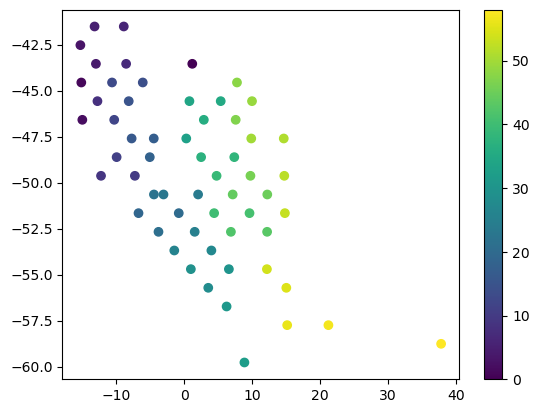

In [8]:

radec = np.array([id2pos[field_id] for field_id in schedule.field_id.values])
ra_shifted = np.where(radec[:, 0] > 180, radec[:, 0] - 360, radec[:, 0])
c = plt.scatter(ra_shifted, radec[:, 1], c = np.arange(len(ra_shifted)))
plt.colorbar(c)

In [9]:
dataset = TelescopeDatasetv0(schedule, id2pos)

In [10]:
SEED = 10
env_name = 'TelescopeEnv-v0'
train_size = 1

seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [11]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'action_dim': dataset.action_dim,
    'hidden_dim': 32,
    'gamma': .99,
    'tau': .0001,
    'device': device,
    'lr': 1e-3,
    'loss_fxn': F.smooth_l1_loss,
    'use_double': True,
    'mode': 'memorization'
}

fit_config = {
    'num_epochs':5000,
    'batch_size': 64,
    # 'learning_start': 
    }

alg = DDQN(**alg_config)

agent_config = {
    'algorithm': alg,
    'name': 'ddqnAgent'
    }

config_prefix = f"-n_unique={dataset._nfields}"
config_prefix += f"-use_double={alg_config['use_double']}"
config_prefix += f"-num_epochs={fit_config['num_epochs']}"
config_prefix += f"-batch_size={fit_config['batch_size']}"
config_prefix += f"-lr={alg_config['lr']}"

agent = Agent(**agent_config)

outdir = f'../results/{env_name}-{config_prefix}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)


In [31]:
dataset

  3%|▎         | 135/5000 [00:00<00:07, 682.03it/s]

Epoch 0: Accuracy = 0.031, Loss = 0.5023
Epoch 100: Accuracy = 0.266, Loss = 0.3557


  6%|▌         | 286/5000 [00:00<00:06, 731.47it/s]

Epoch 200: Accuracy = 0.297, Loss = 0.3867
Epoch 300: Accuracy = 0.359, Loss = 0.3305


 10%|█         | 508/5000 [00:00<00:06, 722.88it/s]

Epoch 400: Accuracy = 0.281, Loss = 0.3841
Epoch 500: Accuracy = 0.234, Loss = 0.3733


 15%|█▍        | 731/5000 [00:01<00:05, 721.96it/s]

Epoch 600: Accuracy = 0.375, Loss = 0.3572
Epoch 700: Accuracy = 0.391, Loss = 0.2598


 17%|█▋        | 872/5000 [00:01<00:06, 671.42it/s]

Epoch 800: Accuracy = 0.453, Loss = 0.3587
Epoch 900: Accuracy = 0.438, Loss = 0.3486


 22%|██▏       | 1090/5000 [00:01<00:05, 702.45it/s]

Epoch 1000: Accuracy = 0.469, Loss = 0.2751
Epoch 1100: Accuracy = 0.500, Loss = 0.3348


 26%|██▌       | 1307/5000 [00:01<00:05, 690.08it/s]

Epoch 1200: Accuracy = 0.547, Loss = 0.3224
Epoch 1300: Accuracy = 0.500, Loss = 0.3188


 30%|███       | 1514/5000 [00:02<00:05, 613.56it/s]

Epoch 1400: Accuracy = 0.516, Loss = 0.3194
Epoch 1500: Accuracy = 0.562, Loss = 0.2531


 35%|███▍      | 1732/5000 [00:02<00:04, 663.41it/s]

Epoch 1600: Accuracy = 0.422, Loss = 0.3278
Epoch 1700: Accuracy = 0.562, Loss = 0.2539


 37%|███▋      | 1867/5000 [00:02<00:05, 615.54it/s]

Epoch 1800: Accuracy = 0.531, Loss = 0.2645
Epoch 1900: Accuracy = 0.625, Loss = 0.2386


 42%|████▏     | 2087/5000 [00:03<00:04, 690.95it/s]

Epoch 2000: Accuracy = 0.516, Loss = 0.2148
Epoch 2100: Accuracy = 0.531, Loss = 0.2014


 46%|████▌     | 2310/5000 [00:03<00:03, 719.65it/s]

Epoch 2200: Accuracy = 0.578, Loss = 0.2252
Epoch 2300: Accuracy = 0.578, Loss = 0.1891


 51%|█████     | 2532/5000 [00:03<00:03, 730.50it/s]

Epoch 2400: Accuracy = 0.531, Loss = 0.3229
Epoch 2500: Accuracy = 0.625, Loss = 0.2347


 54%|█████▎    | 2680/5000 [00:03<00:03, 722.76it/s]

Epoch 2600: Accuracy = 0.531, Loss = 0.2347
Epoch 2700: Accuracy = 0.625, Loss = 0.1611


 58%|█████▊    | 2905/5000 [00:04<00:02, 722.13it/s]

Epoch 2800: Accuracy = 0.578, Loss = 0.1590
Epoch 2900: Accuracy = 0.609, Loss = 0.1647


 63%|██████▎   | 3126/5000 [00:04<00:02, 717.24it/s]

Epoch 3000: Accuracy = 0.609, Loss = 0.1362
Epoch 3100: Accuracy = 0.484, Loss = 0.2776


 65%|██████▌   | 3269/5000 [00:04<00:02, 693.61it/s]

Epoch 3200: Accuracy = 0.531, Loss = 0.1982
Epoch 3300: Accuracy = 0.578, Loss = 0.1398


 70%|██████▉   | 3492/5000 [00:05<00:02, 717.37it/s]

Epoch 3400: Accuracy = 0.562, Loss = 0.1470
Epoch 3500: Accuracy = 0.562, Loss = 0.1637


 74%|███████▍  | 3710/5000 [00:05<00:01, 721.51it/s]

Epoch 3600: Accuracy = 0.531, Loss = 0.1646
Epoch 3700: Accuracy = 0.578, Loss = 0.1469


 79%|███████▊  | 3928/5000 [00:05<00:01, 709.87it/s]

Epoch 3800: Accuracy = 0.750, Loss = 0.1837
Epoch 3900: Accuracy = 0.562, Loss = 0.1331


 81%|████████▏ | 4070/5000 [00:05<00:01, 667.51it/s]

Epoch 4000: Accuracy = 0.609, Loss = 0.1185
Epoch 4100: Accuracy = 0.531, Loss = 0.1414


 86%|████████▌ | 4280/5000 [00:06<00:01, 676.70it/s]

Epoch 4200: Accuracy = 0.547, Loss = 0.1356
Epoch 4300: Accuracy = 0.719, Loss = 0.1214


 90%|████████▉ | 4493/5000 [00:06<00:00, 689.65it/s]

Epoch 4400: Accuracy = 0.641, Loss = 0.0763
Epoch 4500: Accuracy = 0.594, Loss = 0.0532


 94%|█████████▍| 4706/5000 [00:06<00:00, 699.16it/s]

Epoch 4600: Accuracy = 0.641, Loss = 0.0907
Epoch 4700: Accuracy = 0.438, Loss = 0.0779


 98%|█████████▊| 4916/5000 [00:07<00:00, 683.84it/s]

Epoch 4800: Accuracy = 0.594, Loss = 0.0687
Epoch 4900: Accuracy = 0.703, Loss = 0.1157


100%|██████████| 5000/5000 [00:07<00:00, 691.66it/s]


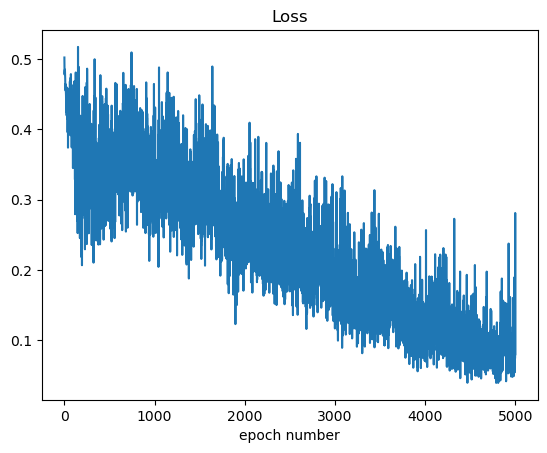

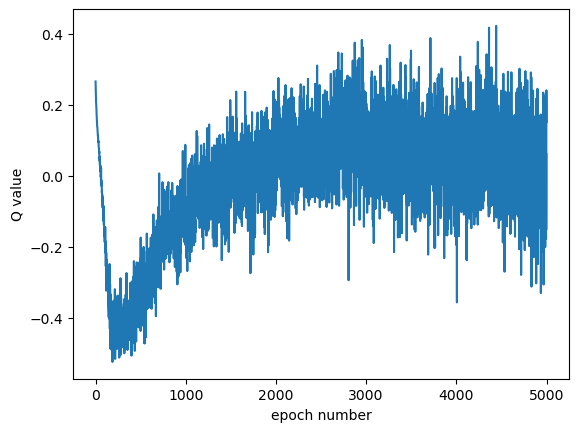

In [12]:
"""Train"""
agent.fit(
    dataset,
    outdir=outdir,
    **fit_config
    )
plt.plot(agent.loss_history)
plt.title('Loss')
plt.xlabel('epoch number')
plt.savefig(fig_outdir + 'train_loss_history.png')
plt.show();
plt.plot(agent.q_history)
plt.xlabel('epoch number')
plt.ylabel('Q value')
plt.savefig(fig_outdir + 'train_q_history.png')

In [18]:
from environments import TelescopeEnv_v0

In [22]:
# for eval step only
env_config = {
    # 'use_separation_reward': True,
    'use_field_id_reward': True
}

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=TelescopeEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

env = gym.make(f"gymnasium_env/{env_name}", dataset=dataset, **env_config)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


In [23]:
"""Evaluate"""
eval_metrics = agent.evaluate(env=env, num_episodes=10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 93.33it/s]

[array([-0.01694915, -0.01694915], dtype=float32), array([ 0., 46.], dtype=float32), array([ 1., 39.], dtype=float32), array([ 2., 12.], dtype=float32), array([ 3., 25.], dtype=float32), array([ 4., 14.], dtype=float32), array([ 5., 52.], dtype=float32), array([ 6., 10.], dtype=float32), array([ 7., 33.], dtype=float32), array([ 8., 47.], dtype=float32), array([ 9., 22.], dtype=float32), array([10.,  3.], dtype=float32), array([11., 13.], dtype=float32), array([12.,  8.], dtype=float32), array([13., 24.], dtype=float32), array([14.      , 30.999998], dtype=float32), array([15.,  1.], dtype=float32), array([16.,  2.], dtype=float32), array([17., 11.], dtype=float32), array([18., 54.], dtype=float32), array([19., 50.], dtype=float32), array([20., 30.], dtype=float32), array([21., 19.], dtype=float32), array([22., 44.], dtype=float32), array([23., 37.], dtype=float32), array([24., 26.], dtype=float32), array([25., 57.], dtype=float32), array([26., 28.], dtype=float32), array([27., 23.], d

In [24]:
target_sequence = env.unwrapped.target_field_ids
eval_sequence = eval_metrics['observations']['ep-1']

/tmp/ipykernel_84292/1549850109.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


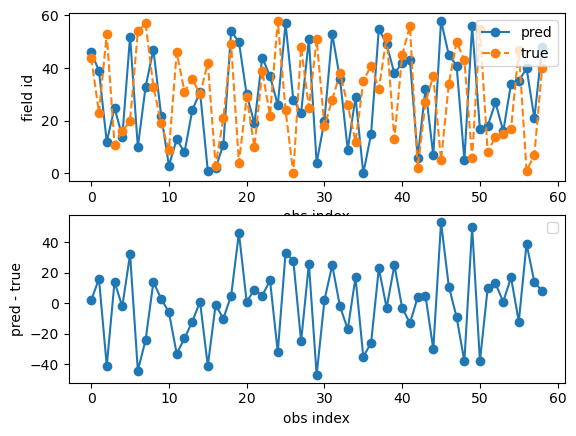

In [17]:
fig, axs = plt.subplots(2)
axs[0].plot(np.arange(len(eval_sequence[1:])), eval_sequence[1:, 1], marker='o', label='pred')
axs[0].plot(np.arange(len(target_sequence)), target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(np.arange(len(eval_sequence[1:])), eval_sequence[1:, 1] - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')

fig.savefig(outdir + 'learned_sequence.png')

In [ ]:
# ===== MEMORIZATION TESTS =====

def create_memorization_dataset(size: int = 100, state_dim: int = 4, action_dim: int = 2):
    """
    Create a small, deterministic dataset for memorization testing
    Each state maps to exactly one optimal action with clear reward signal
    
    Key design choices for easy memorization:
    - All transitions are terminal (dones=1) so target = reward only
    - Optimal action gets reward +1, suboptimal gets reward -1
    - Both actions appear in dataset so network learns the difference
    """
    np.random.seed(42)
    
    # Create twice as many states, we'll use each state twice (once per action)
    unique_states = np.random.randn(size // 2, state_dim)
    
    states = []
    actions = []
    rewards = []
    
    for state in unique_states:
        # Determine optimal action based on first dimension
        optimal_action = 1 if state[0] > 0 else 0
        
        # Add transition with optimal action (high reward)
        states.append(state)
        actions.append(optimal_action)
        rewards.append(1.0)
        
        # Add transition with suboptimal action (low reward)
        states.append(state)
        actions.append(1 - optimal_action)
        rewards.append(-1.0)
    
    states = np.array(states)
    actions = np.array(actions, dtype=np.int64)
    rewards = np.array(rewards)
    
    # Terminal states, so network only needs to learn Q(s,a) = reward
    next_states = np.random.randn(len(states), state_dim)
    dones = np.ones(len(states))
    
    return states, actions, rewards, next_states, dones


def test_memorization(algorithm, dataset, threshold: float = 0.9):
    """
    Test if the algorithm can memorize a small dataset
    This verifies:
    1. Data loading works correctly
    2. Backpropagation is functioning
    3. Network can fit simple patterns
    """
    print("\n" + "="*60)
    print("MEMORIZATION TEST")
    print("="*60)
    
    # Train on small dataset
    print("\nTraining on memorization dataset...")
    algorithm.train(dataset, num_epochs=500, batch_size=32, verbose=True)
    
    # Evaluate memorization accuracy on unique states only
    # Group by states to get the true optimal action
    state_action_map = {}
    for i in range(len(dataset)):
        sample = dataset[i]
        state_tuple = tuple(sample['state'].numpy())
        action = sample['action'].item()
        reward = sample['reward'].item()
        
        if state_tuple not in state_action_map:
            state_action_map[state_tuple] = []
        state_action_map[state_tuple].append((action, reward))
    
    # For each unique state, find the optimal action (highest reward)
    correct = 0
    total = 0
    
    print("\nEvaluating on unique states...")
    for state_tuple, action_rewards in state_action_map.items():
        state = np.array(state_tuple)
        
        # Find optimal action (highest reward)
        optimal_action = max(action_rewards, key=lambda x: x[1])[0]
        
        # Predict action
        pred_action = algorithm.select_action(state, deterministic=True)
        
        if pred_action == optimal_action:
            correct += 1
        total += 1
    
    accuracy = correct / total
    print(f"\nMemorization Accuracy: {accuracy:.2%} ({correct}/{total})")
    
    # Show some example predictions
    print("\nExample predictions (first 5 unique states):")
    for i, (state_tuple, action_rewards) in enumerate(list(state_action_map.items())[:5]):
        if i >= 5:
            break
        state = np.array(state_tuple)
        optimal_action = max(action_rewards, key=lambda x: x[1])[0]
        pred_action = algorithm.select_action(state, deterministic=True)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(algorithm.device)
            q_values = algorithm.q_network(state_tensor).cpu().numpy()[0]
        
        print(f"  State[0]={state[0]:.2f}, Optimal={optimal_action}, Pred={pred_action}, Q={q_values}")
    
    if accuracy >= threshold:
        print("\n✓ PASSED: Algorithm can memorize the dataset")
        print("  This indicates correct implementation of:")
        print("  - Data loading pipeline")
        print("  - Loss computation and backpropagation")
        print("  - Network forward pass")
        return True
    else:
        print("\n✗ FAILED: Algorithm cannot memorize simple dataset")
        print("  Check the following:")
        print("  - Loss function implementation")
        print("  - Gradient flow (check for detached tensors)")
        print("  - Network architecture")
        print("  - Learning rate (might be too low)")
        print("  - Target network updates (tau might be too small)")
        return False


def test_q_value_consistency(algorithm: OfflineRLAlgorithm, dataset: ReplayBuffer):
    """
    Test Q-value consistency on training data
    Q-values should be stable and reasonable
    """
    print("\n" + "="*60)
    print("Q-VALUE CONSISTENCY TEST")
    print("="*60)
    
    q_values = []
    for i in range(min(100, len(dataset))):
        sample = dataset[i]
        state = sample['state'].numpy()
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(algorithm.device)
            q = algorithm.q_network(state_tensor).cpu().numpy()
            q_values.append(q[0])
    
    q_values = np.array(q_values)
    
    print(f"\nQ-value statistics:")
    print(f"  Mean: {q_values.mean():.3f}")
    print(f"  Std:  {q_values.std():.3f}")
    print(f"  Min:  {q_values.min():.3f}")
    print(f"  Max:  {q_values.max():.3f}")
    
    # Check for reasonable values
    if np.isnan(q_values).any() or np.isinf(q_values).any():
        print("✗ FAILED: Q-values contain NaN or Inf")
        return False
    
    if abs(q_values.mean()) > 1000:
        print("✗ WARNING: Q-values are extremely large")
        print("  Consider checking reward scaling or discount factor")
    
    print("✓ PASSED: Q-values are within reasonable range")
    return True


def test_single_batch_overfit(algorithm: OfflineRLAlgorithm):
    """
    Test if algorithm can overfit a single batch
    This is the most basic sanity check - if this fails, gradients aren't flowing
    """
    print("\n" + "="*60)
    print("SINGLE BATCH OVERFIT TEST")
    print("="*60)
    
    # Create a tiny batch
    batch = {
        'state': torch.randn(32, algorithm.state_dim),
        'action': torch.randint(0, algorithm.action_dim, (32,)),
        'reward': torch.randn(32),
        'next_state': torch.randn(32, algorithm.state_dim),
        'done': torch.zeros(32)
    }
    
    print("\nTraining on single batch for 100 iterations...")
    initial_loss = None
    final_loss = None
    
    for i in range(100):
        info = algorithm.train_step(batch)
        if i == 0:
            initial_loss = info['td_loss']
        if i == 99:
            final_loss = info['td_loss']
        
        if (i + 1) % 25 == 0:
            print(f"  Iteration {i+1}: Loss = {info['td_loss']:.6f}")
    
    print(f"\nInitial loss: {initial_loss:.6f}")
    print(f"Final loss:   {final_loss:.6f}")
    print(f"Reduction:    {((initial_loss - final_loss) / initial_loss * 100):.1f}%")
    
    if final_loss < initial_loss * 0.1:
        print("✓ PASSED: Can overfit single batch (loss reduced by >90%)")
        return True
    else:
        print("✗ FAILED: Cannot overfit single batch")
        print("  This indicates a fundamental problem with:")
        print("  - Gradient computation")
        print("  - Optimizer setup")
        print("  - Loss function")
        return False


def test_known_mdp():
    """
    Test on a simple MDP where optimal Q-values are analytically known
    
    Simple Chain MDP:
    States: 0 -> 1 -> 2 -> 3 (goal)
    Actions: 0=left, 1=right
    Rewards: +1 at goal, 0 elsewhere
    
    Optimal Q-values (with γ=0.9):
    Q(s=2, right) = 1.0
    Q(s=1, right) = 0.9
    Q(s=0, right) = 0.81
    """
    print("\n" + "="*60)
    print("KNOWN MDP TEST")
    print("="*60)
    
    gamma = 0.9
    
    # Generate dataset for chain MDP
    # Each state has right action leading to next state
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    
    # Generate transitions (with some noise/exploration)
    for _ in range(200):
        for s in range(3):
            # Right action (optimal)
            states.append([s, 0, 0, 0])
            actions.append(1)
            next_states.append([s+1, 0, 0, 0])
            if s == 2:
                rewards.append(1.0)
                dones.append(1.0)
            else:
                rewards.append(0.0)
                dones.append(0.0)
            
            # Left action (suboptimal) - stays in place
            states.append([s, 0, 0, 0])
            actions.append(0)
            next_states.append([max(0, s-1), 0, 0, 0])
            rewards.append(0.0)
            dones.append(0.0)
    
    dataset = ReplayBuffer(
        np.array(states), np.array(actions), np.array(rewards),
        np.array(next_states), np.array(dones)
    )
    
    # Train algorithm
    algorithm = OfflineRLAlgorithm(state_dim=4, action_dim=2, gamma=gamma, lr=1e-3)
    print("\nTraining on chain MDP...")
    algorithm.train(dataset, num_epochs=300, batch_size=32, verbose=False)
    
    # Check learned Q-values
    expected_q = {
        0: gamma**2,  # 0.81
        1: gamma,     # 0.9
        2: 1.0        # 1.0
    }
    
    print("\nComparing learned Q-values to theoretical optimal:")
    print("State | Expected Q(right) | Learned Q(right) | Error")
    print("-" * 60)
    
    max_error = 0
    for s in range(3):
        state = torch.FloatTensor([[s, 0, 0, 0]]).to(algorithm.device)
        with torch.no_grad():
            q_values = algorithm.q_network(state).cpu().numpy()[0]
        
        learned_q = q_values[1]  # right action
        expected = expected_q[s]
        error = abs(learned_q - expected)
        max_error = max(max_error, error)
        
        print(f"  {s}   |      {expected:.3f}        |      {learned_q:.3f}       | {error:.3f}")
    
    if max_error < 0.15:
        print(f"\n✓ PASSED: Max error {max_error:.3f} < 0.15")
        print("  Bellman updates are working correctly")
        return True
    else:
        print(f"\n✗ FAILED: Max error {max_error:.3f} >= 0.15")
        print("  Check:")
        print("  - Bellman backup implementation")
        print("  - Discount factor (gamma)")
        print("  - Target network updates")
        return False


# ===== EXAMPLE USAGE =====

if __name__ == "__main__":
    # Configuration
    STATE_DIM = 4
    ACTION_DIM = 2
    
    print("="*60)
    print("OFFLINE RL IMPLEMENTATION TESTS")
    print("="*60)
    
    # TEST 1: Single batch overfit (most basic sanity check)
    print("\n[TEST 1/4] Single Batch Overfit")
    algorithm = OfflineRLAlgorithm(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        hidden_dim=128,
        lr=3e-4
    )
    test1_passed = test_single_batch_overfit(algorithm)
    
    # TEST 2: Known MDP with analytical solution
    print("\n[TEST 2/4] Known MDP")
    test2_passed = test_known_mdp()
    
    # TEST 3: Memorization with diverse actions
    print("\n[TEST 3/4] Memorization Test")
    states, actions, rewards, next_states, dones = create_memorization_dataset(
        size=100, state_dim=STATE_DIM, action_dim=ACTION_DIM
    )
    dataset = ReplayBuffer(states, actions, rewards, next_states, dones)
    
    algorithm = OfflineRLAlgorithm(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        hidden_dim=128,
        lr=3e-4
    )
    test3_passed = test_memorization(algorithm, dataset, threshold=0.9)
    
    # TEST 4: Q-value consistency
    print("\n[TEST 4/4] Q-Value Consistency")
    test4_passed = test_q_value_consistency(algorithm, dataset)
    
    # Summary
    print("\n" + "="*60)
    print("TEST SUMMARY")
    print("="*60)
    tests = [
        ("Single Batch Overfit", test1_passed),
        ("Known MDP", test2_passed),
        ("Memorization", test3_passed),
        ("Q-Value Consistency", test4_passed)
    ]
    
    for name, passed in tests:
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"{status} - {name}")
    
    all_passed = all(passed for _, passed in tests)
    
    if all_passed:
        print("\n" + "="*60)
        print("ALL TESTS PASSED ✓")
        print("="*60)
        print("\nYour implementation is ready for full-scale training!")
        print("\nNext steps:")
        print("1. Test on real offline RL benchmarks (D4RL)")
        print("2. Compare to behavioral cloning baseline")
        print("3. Add algorithm-specific components (CQL, IQL, etc.)")
    else:
        print("\n" + "="*60)
        print("SOME TESTS FAILED ✗")
        print("="*60)
        print("\nDebug failed tests before proceeding to real datasets.")

In [30]:
"""
Offline Reinforcement Learning Algorithm Template
with Memorization Tests for Implementation Verification
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import copy


class ReplayBuffer(Dataset):
    """Dataset wrapper for offline RL data"""
    
    def __init__(self, states, actions, rewards, next_states, dones):
        self.states = torch.FloatTensor(states)
        self.actions = torch.LongTensor(actions) if actions.dtype == np.int64 else torch.FloatTensor(actions)
        self.rewards = torch.FloatTensor(rewards)
        self.next_states = torch.FloatTensor(next_states)
        self.dones = torch.FloatTensor(dones)
        
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return {
            'state': self.states[idx],
            'action': self.actions[idx],
            'reward': self.rewards[idx],
            'next_state': self.next_states[idx],
            'done': self.dones[idx]
        }


class QNetwork(nn.Module):
    """Simple Q-network for discrete actions"""
    
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, state):
        return self.net(state)


class OfflineRLAlgorithm:
    """
    Template for offline RL algorithms (e.g., CQL, IQL, TD3+BC)
    Includes memorization tests to verify correct implementation
    """
    
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        hidden_dim: int = 256,
        lr: float = 3e-4,
        gamma: float = 0.99,
        tau: float = 0.005,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.device = device
        
        # Networks
        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_network = copy.deepcopy(self.q_network).to(device)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Metrics
        self.train_metrics = defaultdict(list)
        
    def select_action(self, state: np.ndarray, deterministic: bool = True) -> int:
        """Select action using current policy"""
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state)
            if deterministic:
                action = q_values.argmax(dim=1).item()
            else:
                probs = F.softmax(q_values, dim=1)
                action = torch.multinomial(probs, 1).item()
        return action
    
    def compute_loss(self, batch: Dict[str, torch.Tensor]) -> Tuple[torch.Tensor, Dict]:
        """
        Compute training loss using Double DQN
        
        Double DQN reduces overestimation bias by using:
        - Online network to SELECT the best action
        - Target network to EVALUATE that action's Q-value
        
        Standard DQN:  target = r + γ * max_a' Q_target(s', a')
        Double DQN:    target = r + γ * Q_target(s', argmax_a' Q_online(s', a'))
        """
        states = batch['state'].to(self.device)
        actions = batch['action'].to(self.device)
        rewards = batch['reward'].to(self.device)
        next_states = batch['next_state'].to(self.device)
        dones = batch['done'].to(self.device)
        
        # Current Q-values for taken actions
        current_q = self.q_network(states)
        if actions.dtype == torch.long:
            current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)
        else:
            current_q = (current_q * actions).sum(dim=1)
        
        # Double DQN target calculation
        with torch.no_grad():
            # Use online network to SELECT the best next action
            next_q_online = self.q_network(next_states)
            next_actions = next_q_online.argmax(dim=1, keepdim=True)
            
            # Use target network to EVALUATE the selected action
            next_q_target = self.target_q_network(next_states)
            next_q = next_q_target.gather(1, next_actions).squeeze(1)
            
            # Compute target Q-value
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # TD loss
        td_loss = F.mse_loss(current_q, target_q)
        
        info = {
            'td_loss': td_loss.item(),
            'q_mean': current_q.mean().item(),
            'q_std': current_q.std().item(),
            'target_q_mean': target_q.mean().item()
        }
        
        return td_loss, info
    
    def train_step(self, batch: Dict[str, torch.Tensor]) -> Dict:
        """Single training step"""
        loss, info = self.compute_loss(batch)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self._soft_update()
        
        return info
    
    def _soft_update(self):
        """Soft update of target network"""
        for param, target_param in zip(
            self.q_network.parameters(), 
            self.target_q_network.parameters()
        ):
            target_param.data.copy_(
                self.tau * param.data + (1 - self.tau) * target_param.data
            )
    
    def train(
        self, 
        dataset: ReplayBuffer, 
        num_epochs: int = 100,
        batch_size: int = 256,
        verbose: bool = True
    ):
        """Train the algorithm on offline dataset"""
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(num_epochs):
            epoch_metrics = defaultdict(list)
            
            for batch in dataloader:
                info = self.train_step(batch)
                for key, value in info.items():
                    epoch_metrics[key].append(value)
            
            # Log epoch metrics
            if verbose and (epoch + 1) % 20 == 0:
                avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
                print(f"Epoch {epoch + 1}/{num_epochs}: {avg_metrics}")
            
            for key, values in epoch_metrics.items():
                self.train_metrics[key].append(np.mean(values))


# ===== MEMORIZATION TESTS =====

def create_memorization_dataset(size: int = 100, state_dim: int = 4, action_dim: int = 2):
    """
    Create a small, deterministic dataset for memorization testing
    Each state maps to exactly one optimal action with clear reward signal
    
    Key design choices for easy memorization:
    - All transitions are terminal (dones=1) so target = reward only
    - Optimal action gets reward +1, suboptimal gets reward -1
    - Both actions appear in dataset so network learns the difference
    """
    np.random.seed(42)
    
    # Create twice as many states, we'll use each state twice (once per action)
    unique_states = np.random.randn(size // 2, state_dim)
    
    states = []
    actions = []
    rewards = []
    
    for state in unique_states:
        # Determine optimal action based on first dimension
        optimal_action = 1 if state[0] > 0 else 0
        
        # Add transition with optimal action (high reward)
        states.append(state)
        actions.append(optimal_action)
        rewards.append(1.0)
        
        # Add transition with suboptimal action (low reward)
        states.append(state)
        actions.append(1 - optimal_action)
        rewards.append(-1.0)
    
    states = np.array(states)
    actions = np.array(actions, dtype=np.int64)
    rewards = np.array(rewards)
    
    # Terminal states, so network only needs to learn Q(s,a) = reward
    next_states = np.random.randn(len(states), state_dim)
    dones = np.ones(len(states))
    
    return states, actions, rewards, next_states, dones


def test_memorization(algorithm: OfflineRLAlgorithm, dataset: ReplayBuffer, threshold: float = 0.9):
    """
    Test if the algorithm can memorize a small dataset
    This verifies:
    1. Data loading works correctly
    2. Backpropagation is functioning
    3. Network can fit simple patterns
    """
    print("\n" + "="*60)
    print("MEMORIZATION TEST")
    print("="*60)
    
    # Train on small dataset
    print("\nTraining on memorization dataset...")
    algorithm.train(dataset, num_epochs=500, batch_size=32, verbose=True)
    
    # Evaluate memorization accuracy on unique states only
    # Group by states to get the true optimal action
    state_action_map = {}
    for i in range(len(dataset)):
        sample = dataset[i]
        state_tuple = tuple(sample['state'].numpy())
        action = sample['action'].item()
        reward = sample['reward'].item()
        
        if state_tuple not in state_action_map:
            state_action_map[state_tuple] = []
        state_action_map[state_tuple].append((action, reward))
    
    # For each unique state, find the optimal action (highest reward)
    correct = 0
    total = 0
    
    print("\nEvaluating on unique states...")
    for state_tuple, action_rewards in state_action_map.items():
        state = np.array(state_tuple)
        
        # Find optimal action (highest reward)
        optimal_action = max(action_rewards, key=lambda x: x[1])[0]
        
        # Predict action
        pred_action = algorithm.select_action(state, deterministic=True)
        
        if pred_action == optimal_action:
            correct += 1
        total += 1
    
    accuracy = correct / total
    print(f"\nMemorization Accuracy: {accuracy:.2%} ({correct}/{total})")
    
    # Show some example predictions
    print("\nExample predictions (first 5 unique states):")
    for i, (state_tuple, action_rewards) in enumerate(list(state_action_map.items())[:5]):
        if i >= 5:
            break
        state = np.array(state_tuple)
        optimal_action = max(action_rewards, key=lambda x: x[1])[0]
        pred_action = algorithm.select_action(state, deterministic=True)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(algorithm.device)
            q_values = algorithm.q_network(state_tensor).cpu().numpy()[0]
        
        print(f"  State[0]={state[0]:.2f}, Optimal={optimal_action}, Pred={pred_action}, Q={q_values}")
    
    if accuracy >= threshold:
        print("\n✓ PASSED: Algorithm can memorize the dataset")
        print("  This indicates correct implementation of:")
        print("  - Data loading pipeline")
        print("  - Loss computation and backpropagation")
        print("  - Network forward pass")
        return True
    else:
        print("\n✗ FAILED: Algorithm cannot memorize simple dataset")
        print("  Check the following:")
        print("  - Loss function implementation")
        print("  - Gradient flow (check for detached tensors)")
        print("  - Network architecture")
        print("  - Learning rate (might be too low)")
        print("  - Target network updates (tau might be too small)")
        return False


def test_q_value_consistency(algorithm: OfflineRLAlgorithm, dataset: ReplayBuffer):
    """
    Test Q-value consistency on training data
    Q-values should be stable and reasonable
    """
    print("\n" + "="*60)
    print("Q-VALUE CONSISTENCY TEST")
    print("="*60)
    
    q_values = []
    for i in range(min(100, len(dataset))):
        sample = dataset[i]
        state = sample['state'].numpy()
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(algorithm.device)
            q = algorithm.q_network(state_tensor).cpu().numpy()
            q_values.append(q[0])
    
    q_values = np.array(q_values)
    
    print(f"\nQ-value statistics:")
    print(f"  Mean: {q_values.mean():.3f}")
    print(f"  Std:  {q_values.std():.3f}")
    print(f"  Min:  {q_values.min():.3f}")
    print(f"  Max:  {q_values.max():.3f}")
    
    # Check for reasonable values
    if np.isnan(q_values).any() or np.isinf(q_values).any():
        print("✗ FAILED: Q-values contain NaN or Inf")
        return False
    
    if abs(q_values.mean()) > 1000:
        print("✗ WARNING: Q-values are extremely large")
        print("  Consider checking reward scaling or discount factor")
    
    print("✓ PASSED: Q-values are within reasonable range")
    return True


# ===== EXAMPLE USAGE =====

if __name__ == "__main__":
    # Configuration
    STATE_DIM = 4
    ACTION_DIM = 2
    
    # Create memorization dataset
    print("Creating memorization dataset...")
    states, actions, rewards, next_states, dones = create_memorization_dataset(
        size=100, state_dim=STATE_DIM, action_dim=ACTION_DIM
    )
    dataset = ReplayBuffer(states, actions, rewards, next_states, dones)
    
    # Initialize algorithm
    print("Initializing offline RL algorithm...")
    algorithm = OfflineRLAlgorithm(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        hidden_dim=128,
        lr=3e-4,
        gamma=0.99
    )
    
    # Run memorization tests
    mem_passed = test_memorization(algorithm, dataset, threshold=0.9)
    q_passed = test_q_value_consistency(algorithm, dataset)
    
    if mem_passed and q_passed:
        print("\n" + "="*60)
        print("ALL TESTS PASSED ✓")
        print("="*60)
        print("\nYour implementation is ready for full-scale training!")
        print("\nNext steps:")
        print("1. Replace compute_loss() with your specific algorithm")
        print("2. Add any algorithm-specific components (e.g., CQL penalty)")
        print("3. Test on larger offline datasets")
        print("4. Evaluate on the target environment")
    else:
        print("\n" + "="*60)
        print("SOME TESTS FAILED ✗")
        print("="*60)
        print("\nPlease debug your implementation before proceeding.")

Creating memorization dataset...
Initializing offline RL algorithm...

MEMORIZATION TEST

Training on memorization dataset...
Epoch 20/500: {'td_loss': 0.37509244680404663, 'q_mean': 0.055436279624700546, 'q_std': 0.5906882733106613, 'target_q_mean': 0.109375}
Epoch 40/500: {'td_loss': 0.2555446960031986, 'q_mean': -0.053337834775447845, 'q_std': 0.7347664535045624, 'target_q_mean': -0.109375}
Epoch 60/500: {'td_loss': 0.1607329547405243, 'q_mean': -0.019686521962285042, 'q_std': 0.8652986288070679, 'target_q_mean': 0.0}
Epoch 80/500: {'td_loss': 0.17779018729925156, 'q_mean': -0.006603382993489504, 'q_std': 0.834034338593483, 'target_q_mean': 0.0}
Epoch 100/500: {'td_loss': 0.10453723650425673, 'q_mean': -0.03668915946036577, 'q_std': 1.0047210156917572, 'target_q_mean': 0.0}
Epoch 120/500: {'td_loss': 0.10433929599821568, 'q_mean': 0.009772537276148796, 'q_std': 0.8861995190382004, 'target_q_mean': 0.0}
Epoch 140/500: {'td_loss': 0.07860649842768908, 'q_mean': 0.1299070566892624, 'q_